In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


In [7]:
#==============================================================
# The first step is to import the matrices from the test problem
#==============================================================
#Shape printing codes: 1 = print shapes of variables, 0 = no print
import_print   = 0
lu_print       = 0
standard_print = 0
#==============================================================
# Import
LP_test = sp.io.loadmat('./LP_test.mat')
# Convert to float
C = LP_test['C'].astype(float)
Pd_max = LP_test['Pd_max'].astype(float)
Pg_max = LP_test['Pg_max'].astype(float)
U = LP_test['U'].astype(float)
# Check shapes
if import_print == 1:
    print("        Shapes:")
    print("     C:",C.shape)
    print("Pd_max:",Pd_max.shape)
    print("Pg_max:",Pg_max.shape)
    print("     U:",U.shape)
#==============================================================
# We first want to get the problem into the form as described in problem 3:
#
#         o --------------------- o
#         |   min   g.T @ x       |
#         |    x                  |
#         |   s.t.  A.T @ x  = b  | 
#         |          l <= x <= u  |
#         o --------------------- o
#
#    x = |pd|    with x.shape = (45,1)
#        |pg|    pd and pg are variables, not fixed Pd and Pg
# 
#    g = |-U|      so g.shape = (45,1)
#        | C| 
#
#    A = | e|    with A.shape = (45,1)
#        |-e|    Where "e" is a vector of 1s with shape(Pd)
#                and "-e" is a vector of -1s with shape(Pg)
#
#    b = 0         so b.shape = ( 1,1)
#
#    l = | 0|    with l.shape = (45,1)
#
#    u = |Pd|      so u.shape = (45,1)
#        |Pg|    here Pd and Pg are the imported variables
#
#==============================================================
# Build the matrices into the form
g = np.vstack((-U,C))
A = np.vstack((np.ones_like(Pd_max),-np.ones_like(Pg_max)))
b = np.array([[0]])
l = np.zeros_like(g)
u = np.vstack((Pd_max,Pg_max))
# Check Shapes
if lu_print == 1:
    print("        Shapes:")
    print("     g:",g.shape)
    print("     A:",A.shape)
    print("     b:",b.shape)
    print("     l:",l.shape)
    print("     u:",u.shape)
#==============================================================
# Next we want to convert the problem to fit into the solver described in lecture 07B
#
#         o --------------------- o
#         |   min   g.T @ x       |
#         |    x                  |
#         |   s.t.  A.T @ x  = b  | 
#         |               x >= 0  |
#         o --------------------- o
#
# Because of the structure of this problem, the lower bound is actually already 0, so we have:
#
#               0 <= x <= u
#
# We can then define:
#
#              z = |x-0| = | x |     
#                  |u-x|   |u-x|                                  
#
# We want to maintain A.T @ x = b, so with z we have:
#
#                    |A|   @ z = |A.T O.T| @ z = b        with O.shape = A.shape
#                    |O|.T                             where O is a matrix of 0s
#
# If we say that the vector x has N elements, we have then that z has 2N elements.
# For each n in range(N), we then have:
#
#                    z_{n} + z_{n+N} = x_{n} + u_{n} - x_{n} = u_{n}
#
# These are then N new equality constraints. We add these to our constraints matrix:
#
#       A_bar.T = |A.T       O.T       | so we have: A_bar.T @ z = |b|
#                 |1 0 0 ... 1 0 0 ... |                           |u|  
#                 |0 1 0 ... 0 1 0 ... |      
#                 | ...       ...      |       This means: A_bar = |A I|
#                 | ... 0 1 0 ... 0 1 0|                           |O I|
#                 | ... 0 0 1 ... 0 0 1|       With I.shape = (len(u),len(u))    
#
# Since we have changed variables, we then also have to change our g. We want to minimize g.T @ x. 
# Luckily for us, z contains all of x as elements. This means we can just have:
#
#         g_bar = |g| so we have: g_bar.T @ z = g.T @ x    with o.shape = (u-x).shape = x.shape
#                 |o|                                                 where o is a vector of 0s
# 
# This then gives us:
#
#         o ------------------------- o
#         |   min   g_bar.T @ z       |
#         |    z                  |b| |
#         |   s.t.  A_bar.T @ z = |u| |
#         |                  z >= 0   |
#         o ------------------------- o 
#==============================================================
#Setting up our variables: 
un, _ = u.shape
z     = np.vstack((  np.ones_like(g),
                   u-np.ones_like(g))) #note here that g.shape = x.shape
A_bar = np.block([[       A        ,np.eye(un)],  #A_bar = |A I|
                  [np.zeros_like(A),np.eye(un)]]) #        |O I|
b_bar = np.vstack((b,
                   u))
g_bar = np.vstack((g,
                   np.zeros_like(g)))
#Checking shapes:
if standard_print == 1:
    print("        Shapes:")
    print(" g_bar:",g_bar.shape)
    print(" A_bar:",A_bar.shape)
    print(" b_bar:",b_bar.shape)
    print("     z:",z.shape)

In [5]:
def LPippd(g,A,b,x="Empty"):
    #==============================================================
    #The aim is to solve:
    #
    #       o--------------------o--------------------o
    #       | min   g.T @ x                  Lagrange |
    #       |  x                         Multipliers: |
    #       | s.t.  A.T @ x  = b          mu, or "mu" |
    #       |             x >= 0      lambda, or "la" |
    #       o--------------------o--------------------o
    #
    # This solver is based off of linear program interior partial dual solver made by
    # John Bagterp Joergensen in the file "LPippd.m" offered in Module 5 Lecutre 07B
    # combined with the pseudocode offered on page 19/22 of the Module 5 Lecture 07B
    # document "LinearOptimizationIP" on DTU Learn.
    #==============================================================
    #Initialize Variables:
    #==============================================================
    maxit = 100
    tolL = 1.0e-9
    tolA = 1.0e-9
    tols = 1.0e-9
    eta = 0.99
    n, m = A.shape
    if type(x) == str: #in case x is not provided, we initialize as ones.
        x = np.ones((n,1))
    la = np.ones( (n,1)) #la is lambda
    mu = np.zeros((m,1))
    #==============================================================
    # Next we define necessary functions:
    #==============================================================
    #Define a function for computing residuals:
    def Residuals(g,A,b,x,la,mu):
        n, m = A.shape
        rL = g - (A @ mu) - la
        rA = (A.T @ x) - b
        rC = np.multiply(x,la)
        s = np.sum(rC)/n
        return rL, rA, rC, s
    #Define a function for checking for convergence:
    def Convergence(rL, rA, s,tolL=1.0e-9,tolA=1.0e-9,tols=1.0e-9):
        if np.linalg.norm(rL,ord=np.inf) <= tolL and np.linalg.norm(rA,ord=np.inf) <= tolA and np.abs(s) <= tols:
            return True
        else: return False
    #Function for finding alpha and beta
    def FindAlpha(z,dz,mult=1): #find smallest a s.t. z + a * dz >= 0
        dmask = dz < 0
        if len(dz[dmask]) == 0:
            a = 1
        else:
            a_vec = -z[dmask]/dz[dmask]
            a = min(a_vec)
            if a <= 0:
                raise ValueError("###---a nonpositive---###")
        a *= mult
        return a
    #==============================================================
    # Next is the while loop construction:
    #==============================================================
    rL, rA, rC, s = Residuals(g,A,b,x,la,mu)
    ResidualsArray = []
    ResidualsArray.append([np.linalg.norm(rL,ord=2),np.linalg.norm(rA,ord=2),np.linalg.norm(rC,ord=2),s]) #we are asked to report on the residuals as a function of iteration
    it_count = 0
    while it_count < maxit and not Convergence(rL,rA,s,tolL,tolA,tols):
        it_count+=1

        #==============================================================
        # Make the Hessian matrix and take its Cholesky decomposition:
        #==============================================================
        x_lainv = np.divide(x,la)
        H = A.T @ np.diag(x_lainv.flatten()) @ A
        L = sp.linalg.cholesky(H, lower=True) #Here we use a scipy function to perform the Cholesky decomposition

        #==============================================================
        # Affine step calculation + Centering parameter
        #==============================================================
        # Prepare the affine right hand side
        temp_rhs_pre = np.multiply(x,rL)+rC
        temp_rhs = np.divide(temp_rhs_pre,la)
        rhs = -rA + (A.T @ temp_rhs)
        # Next we solve H @ dmu = L @ L.T @ dmu = rhs
        midd = sp.linalg.solve_triangular(L,rhs,lower=True) 
        dmu = sp.linalg.solve_triangular(L.T,midd,lower=False)
        # Then calculate dx and dlambda
        dx  = np.multiply(x_lainv,A @ dmu) - temp_rhs
        temp_dla = - (rC + np.multiply(la,dx))
        dla = np.divide(temp_dla,x)
        alpha = FindAlpha(x,dx)
        beta  = FindAlpha(la,dla)
        # Then we get the affine steps
        xaff = x + (alpha * dx)
        laaff = la + (beta * dla)
        saff = np.sum(np.multiply(xaff,laaff))/n
        # And centering parameter
        sigma = (saff/s)**3

        #==============================================================
        # Centering step calculation
        #==============================================================
        # Preparing the centering right hand side
        rC_bar = rC + np.multiply(dx,dla) - (sigma*s)
        temp_rhs_pre = np.multiply(x,rL) + rC_bar
        temp_rhs = np.divide(temp_rhs_pre,la)
        rhs = -rA + (A.T@temp_rhs)
        # Next we solve H @ dmu = L @ L.T @ dmu = rhs
        midd = sp.linalg.solve_triangular(L,rhs,lower=True) 
        dmu = sp.linalg.solve_triangular(L.T,midd,lower=False)
        # And calculate dc and dlambda
        dx = np.multiply(x_lainv,A @ dmu) - temp_rhs
        temp_dla = - (rC_bar + np.multiply(la,dx))
        dla = np.divide(temp_dla,x)
        alpha = FindAlpha(x,dx)
        beta  = FindAlpha(la,dla)
        #Then we take the centering step
        x  = x  + (eta * alpha * dx)
        mu = mu + (eta * beta * dmu)
        la = la + (eta * beta * dla)

        #==============================================================
        # Recompute residuals
        #==============================================================
        rL, rA, rC, s = Residuals(g,A,b,x,la,mu)
        ResidualsArray.append([np.linalg.norm(rL,ord=2),np.linalg.norm(rA,ord=2),np.linalg.norm(rC,ord=2),s]) #keep track of residuals
    if it_count == maxit:
        raise ValueError("####---Too Many Iterations---##")
    return x, mu, la, ResidualsArray


Real Solution:
 [225. 234. 213. 228. 231.   0. 218.   0.   0. 225. 209.   0. 222. 242.
   0. 245.   0. 217.   0. 242. 243. 230. 204. 230.   0.   0. 245.   0.
 230. 203. 406.   0. 560. 310. 460.  45. 165.   0. 420.   0. 785.   0.
   0. 410. 975.]
Our Solutiuon:
 [2.25000000e+02 2.34000000e+02 2.13000000e+02 2.28000000e+02
 2.31000000e+02 1.18259031e-11 2.18000000e+02 2.37603820e-12
 5.02019911e-11 2.25000000e+02 2.09000000e+02 8.78828156e-12
 2.22000000e+02 2.42000000e+02 5.75502352e-12 2.45000000e+02
 2.44308662e-12 2.17000000e+02 2.79209835e-12 2.42000000e+02
 2.43000000e+02 2.30000000e+02 2.04000000e+02 2.30000000e+02
 5.73157042e-12 3.02620719e-12 2.45000000e+02 5.76978708e-12
 2.30000000e+02 2.03000000e+02 4.19294141e+02 2.03911331e-12
 5.58911755e+02 3.10000000e+02 4.60000000e+02 3.43786244e+01
 1.63415480e+02 7.65126659e-12 4.20000000e+02 4.00651951e-12
 7.85000000e+02 3.12586712e-12 1.65251733e-12 4.10000000e+02
 9.75000000e+02]
Solution Distance: 17.124333088216847


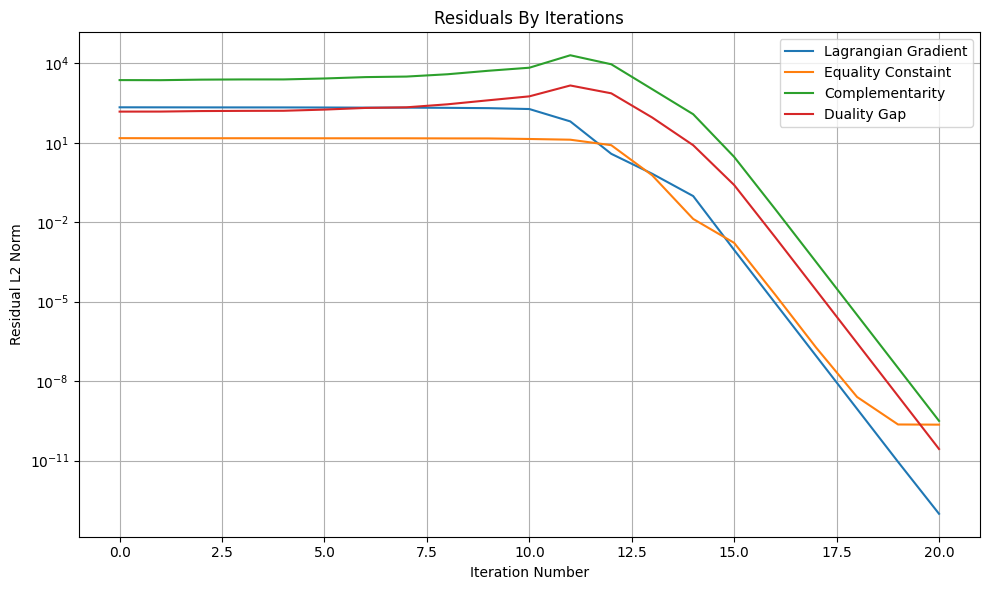

In [6]:
#==============================================================
# Solution Baseline:
#==============================================================
# The goal here is to get the scipy solution to compare with
bounds = []
ln, _ = l.shape
for i in range(ln):
    bounds.append((float(l.flatten()[i]), float(u.flatten()[i])))
sol = sp.optimize.linprog(c=g.flatten(),A_eq=A.T,b_eq=b.flatten(),bounds=bounds,method='highs')
realx = np.array(sol.x)
print("Real Solution:\n", realx)

#==============================================================
# Our Solution:
#==============================================================
zout, mu, la, res = LPippd(g_bar,A_bar,b_bar,z)
zn, _ = zout.shape
xout = np.array(zout.flatten()[0:int(zn/2)])
print("Our Solutiuon:\n", xout)

#==============================================================
# Comparison:
#==============================================================
print("Solution Distance:", np.linalg.norm(realx-xout,ord=2))

#==============================================================
# Plotting residuals:
#==============================================================
# Here we plot the residuals as a funciton of iteration:
res = np.array(res)
res_names = ["Lagrangian Gradient", "Equality Constaint", "Complementarity", "Duality Gap"]
plt.figure(figsize=(10, 6))

for i in range(res.shape[1]):
    plt.plot(res[:, i], label=res_names[i])

plt.xlabel('Iteration Number')
plt.ylabel('Residual L2 Norm')
plt.title('Residuals By Iterations')
plt.yscale('log') 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()